In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [7]:
from helpers import *

In [8]:
module = fc.eightb.preselection.ranked_quadh
signal = ObjIter([Tree(fn, use_gen=False) for fn in module.signal_list[::3]])
bkg = ObjIter([Tree(module.QCD_B_List, use_gen=False), Tree(module.TTJets, use_gen=False)])

100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


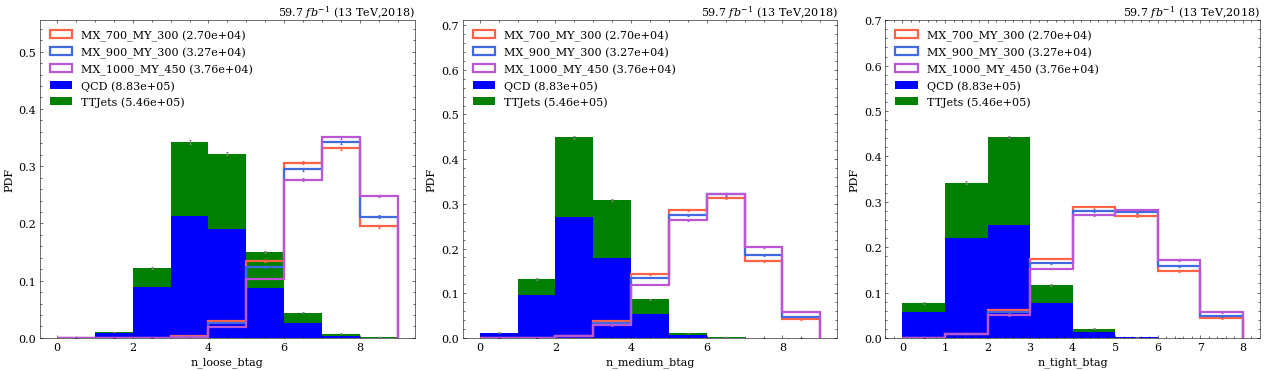

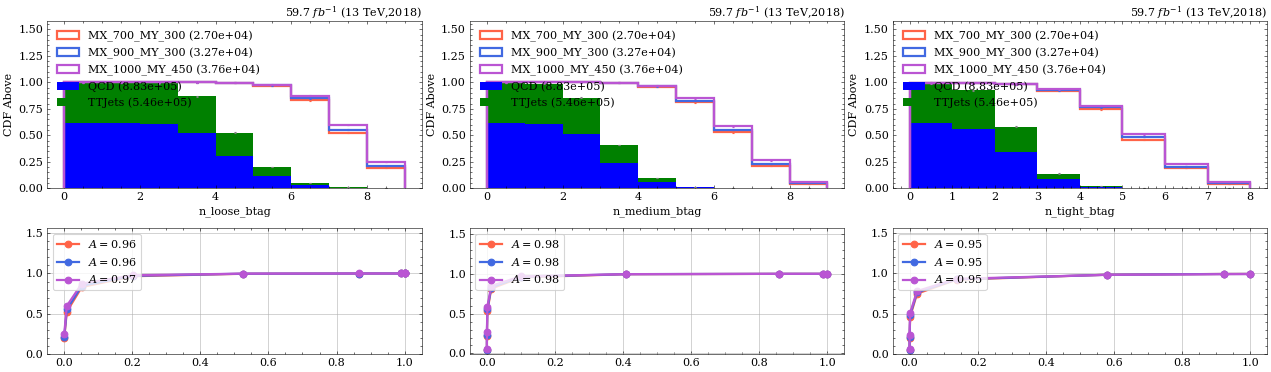

In [9]:
study.quick(
    signal+bkg, legend=True,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    dim=(-1,3),
    efficiency=True
)

study.quick(
    signal+bkg, legend=True,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    dim=(-1,3),
    cumulative=-1, correlation=True, c_legend_frameon=True,
)

In [10]:
(signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ptordered=True))
(signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d', 'higgs', ptordered=True))

[None, None, None, None, None]

In [11]:
def get_features(t):
  def get_j_features(t, i):
    label = {0:'even',1:'odd'}
    btagmulti = {f'{label.get(i)}_{wplabels[wp+1]}_btag':ak.sum(t.jet_btag[:,i::2]>jet_btagWP[wp+1], axis=-1) for wp in range(3)}
    btagmulti.update(
      **{f'{label.get(i)}_btagavg':ak.mean(t.jet_btag[:,i::2], axis=-1)}
    )
    return btagmulti


  t.extend(
    **get_j_features(t, 0),
    **get_j_features(t, 1),
  )

(signal+bkg).apply(get_features)

[None, None, None, None, None]

100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


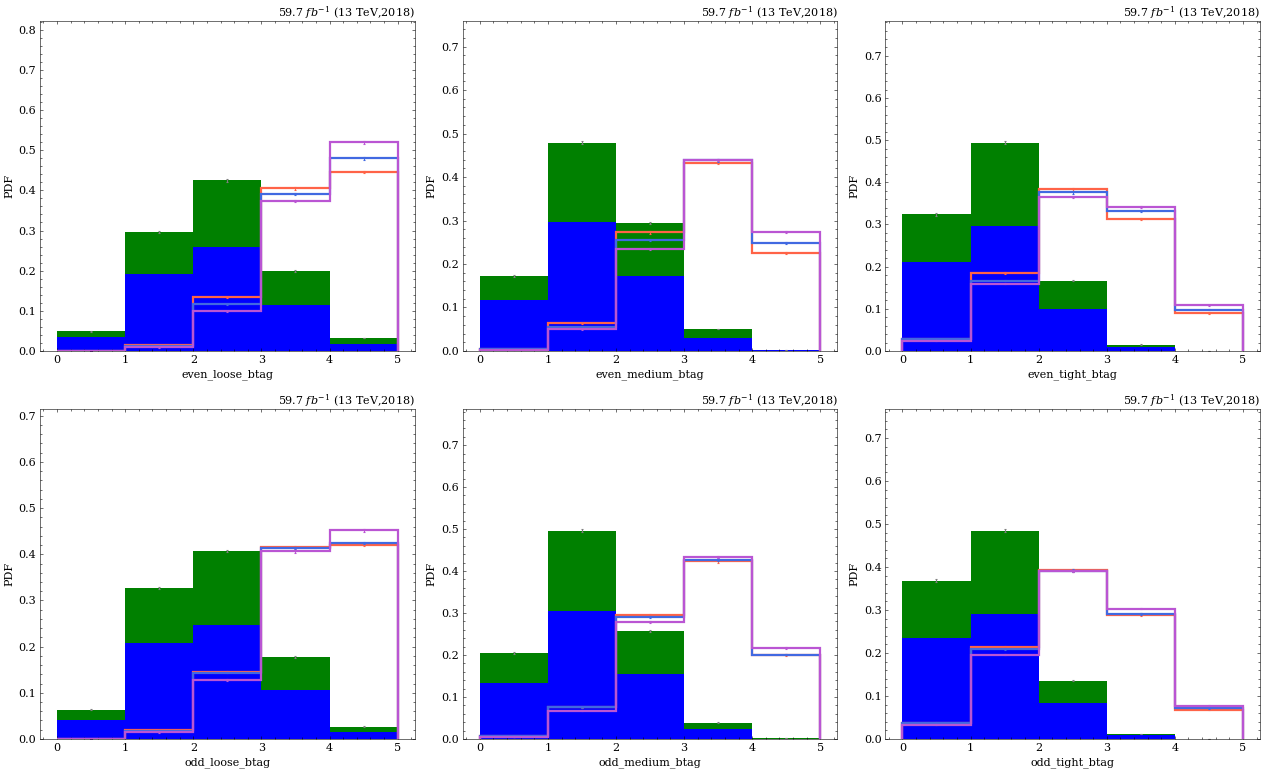

In [12]:
study.quick(
    signal + bkg,
    varlist=[f'{y}_{var}' for y in ('even','odd') for var in ('loose_btag','medium_btag','tight_btag')],
    binlist=[np.arange(6)]*6,
    efficiency=True,
)

In [14]:
y_LL_z_r = grid_region_search(bkg, 'even_medium_btag', 'odd_medium_btag')

100%|██████████| 400/400 [00:18<00:00, 21.89it/s]

N Regions in acceptance (0.1): 21


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


[1 2 5] [1 2 5]
(C/D) K factor: 0.623
(A/B) K target: 0.392
ABCD  % error:  58.92%



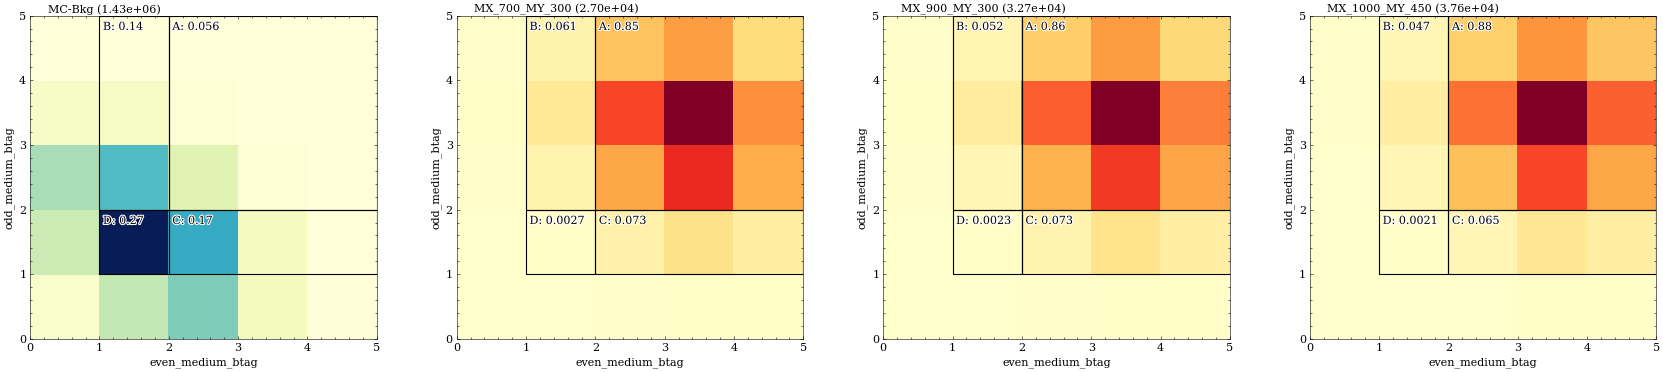

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


[0 1 2] [0 1 2]
(C/D) K factor: 5.747
(A/B) K target: 4.229
ABCD  % error:  35.89%



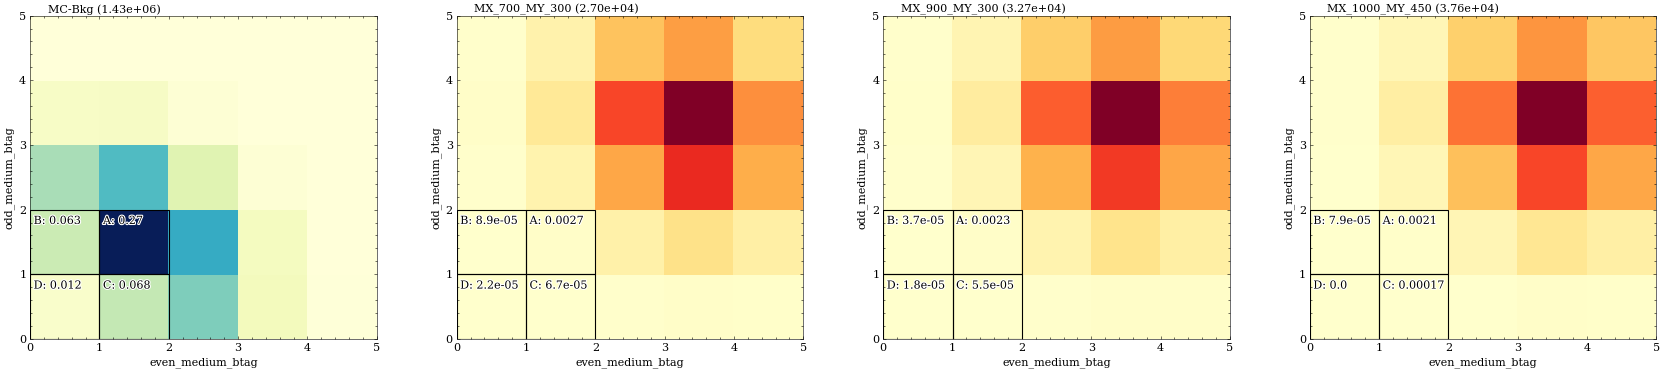

In [16]:
is_sr = (RR[:,0,1] == 2) & (RR[:,1,1] == 2) & (RR[:,0,2] == 5) & (RR[:,1,2] == 5)
has_sr = (RR[:,0,2] > 2) & (RR[:,1,2] > 2)

# has_vr = (RR[:,0,2] == 4) & (RR[:,1,2] == 3)

y_sr = sort_regions(RR, y_LL_z_r, is_sr)[:1]
y_vr = sort_regions(RR, y_LL_z_r, ~has_sr)[:1]
regions = np.concatenate([y_sr ,y_vr])

# regions = sort_regions(RR, y_LL_z_r)[:1]

for x_r, y_r in regions:
    abcd_region = draw_abcd(x_r=x_r, y_r=y_r)
    study.quick2d(
    signal+bkg,
    xvarlist=['even_medium_btag'],
    yvarlist=['odd_medium_btag'],
    binlist=[np.arange(6)]*6,
    exe=abcd_region,
    # interp=True,
    )
    print(x_r, y_r)
    region_score(**abcd_region.store[0])
    plt.show()

--- ABCD Results ---
k = 6.232e-01
k*(b/a)-1  = 58.92%
BDT(b)/a-1 = 60.60%



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


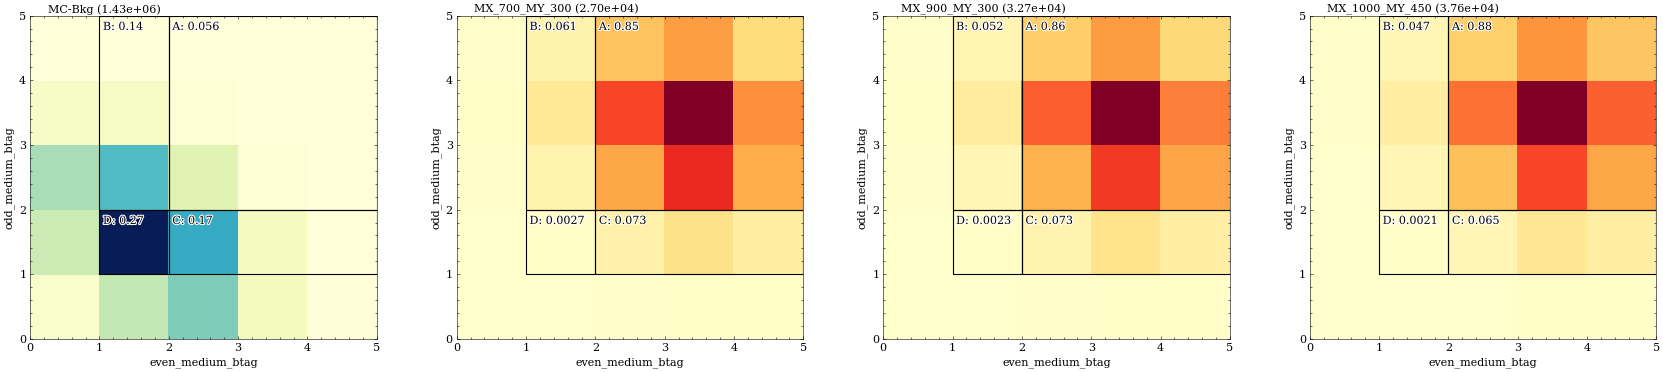

100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


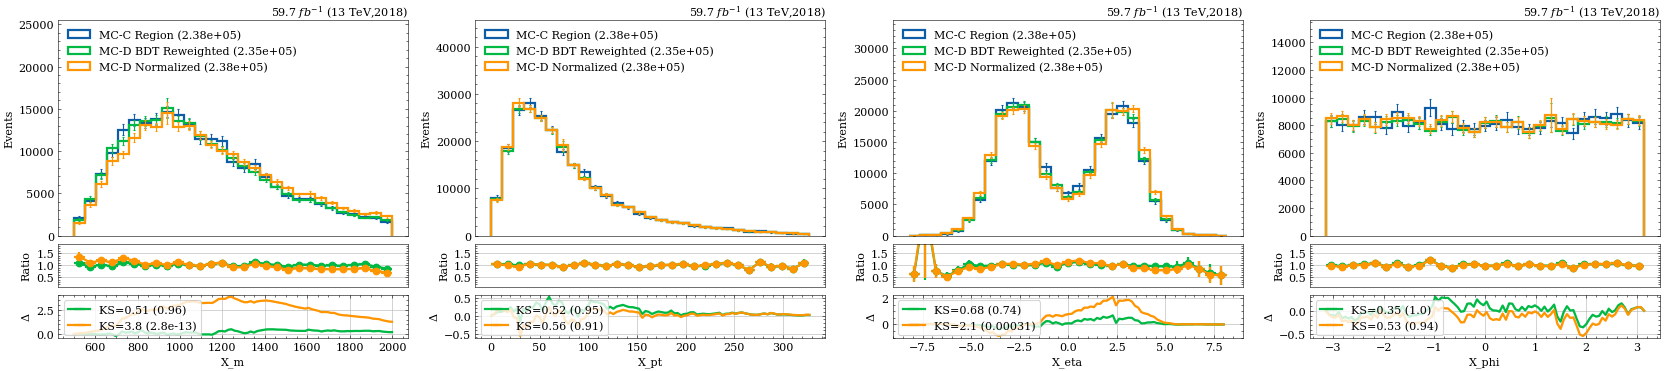

100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


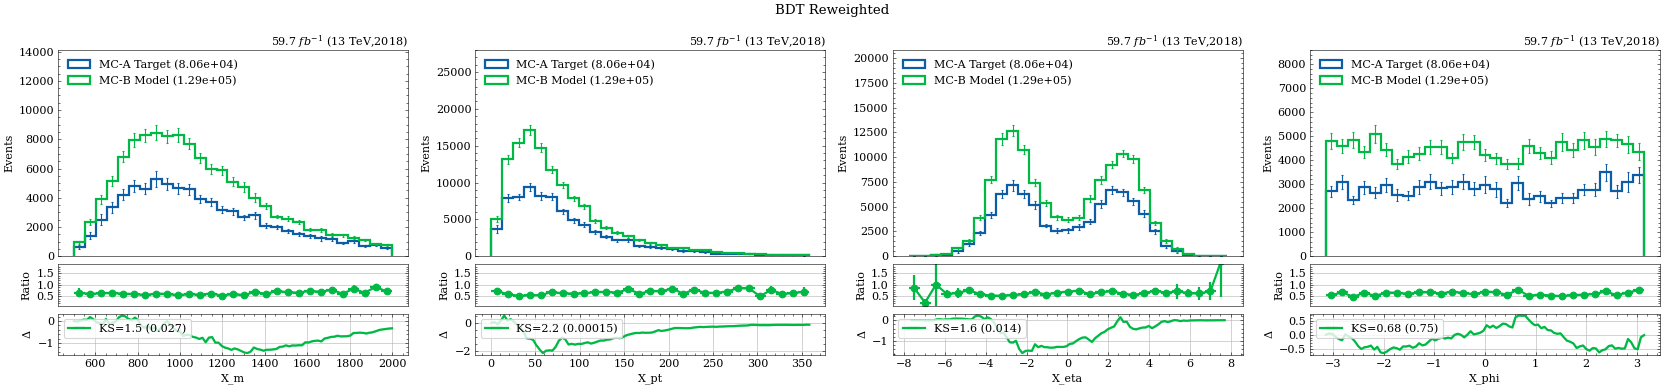

100%|██████████| 1/1 [00:29<00:00, 29.61s/it]


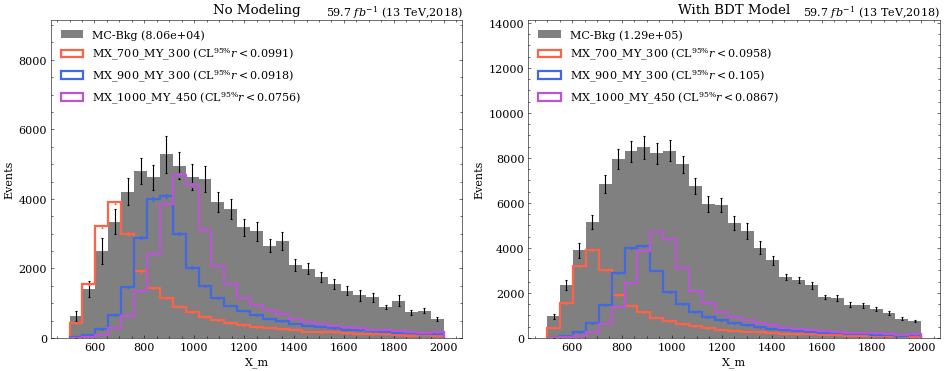

In [17]:
sr_bdt = train_and_evaluate(
    signal, bkg,
    features=['X_m','X_pt','X_eta','X_phi'],
    x_v='even_medium_btag', y_v='odd_medium_btag',
    x_r=y_sr[0][0], y_r=y_sr[0][1]
)

--- ABCD Results ---
k = 5.747e+00
k*(b/a)-1  = 35.89%
BDT(b)/a-1 = 49.25%



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


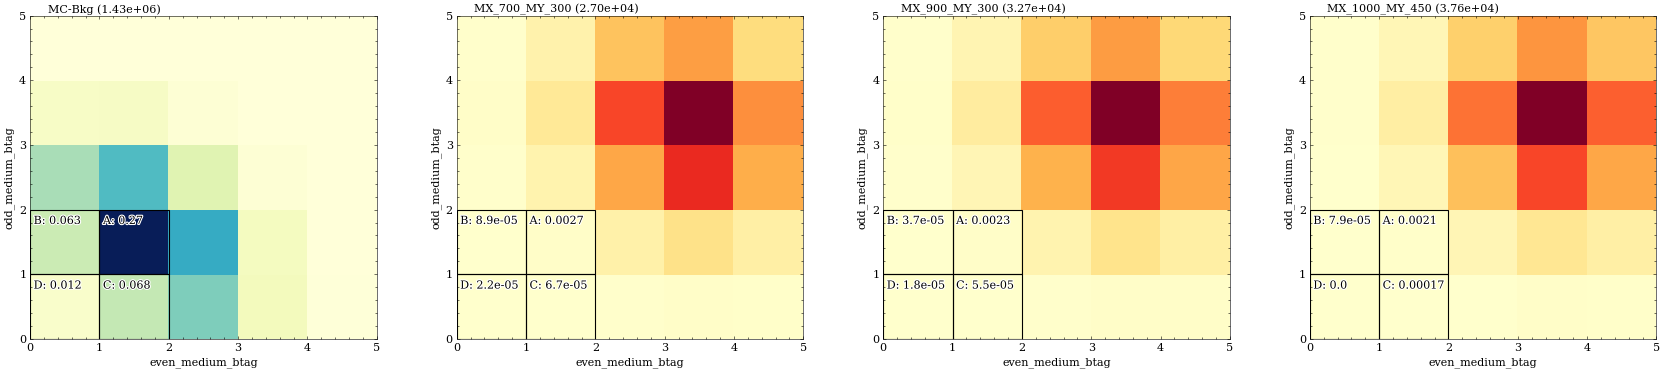

100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


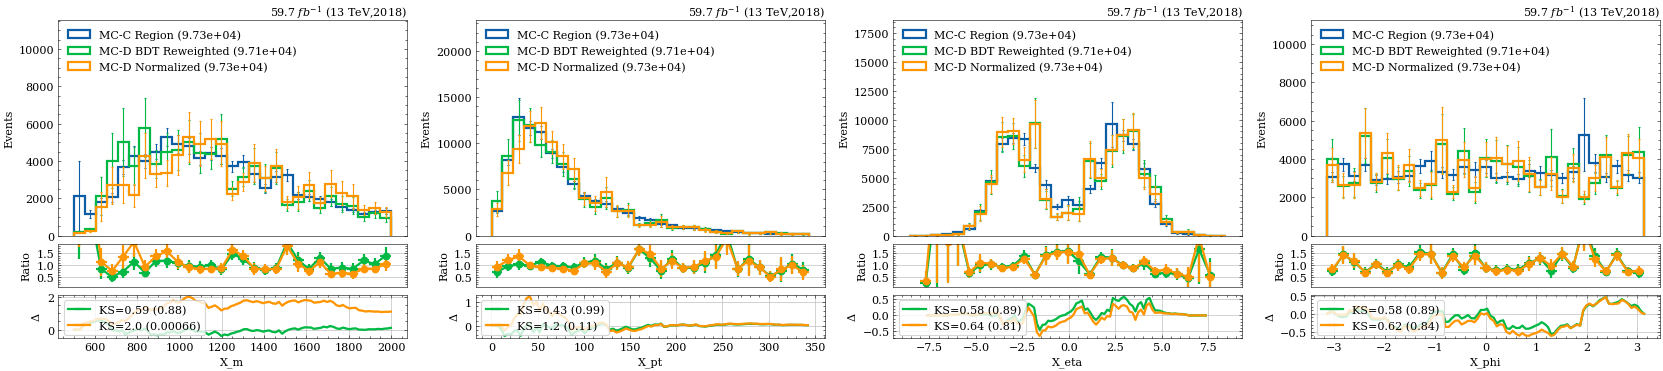

100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


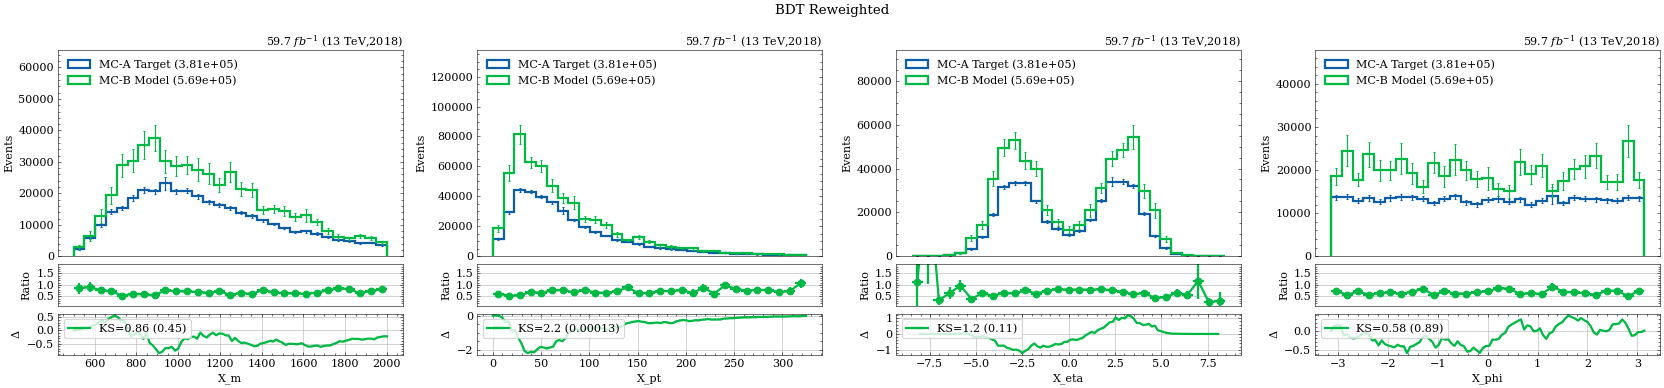

100%|██████████| 1/1 [00:30<00:00, 30.24s/it]


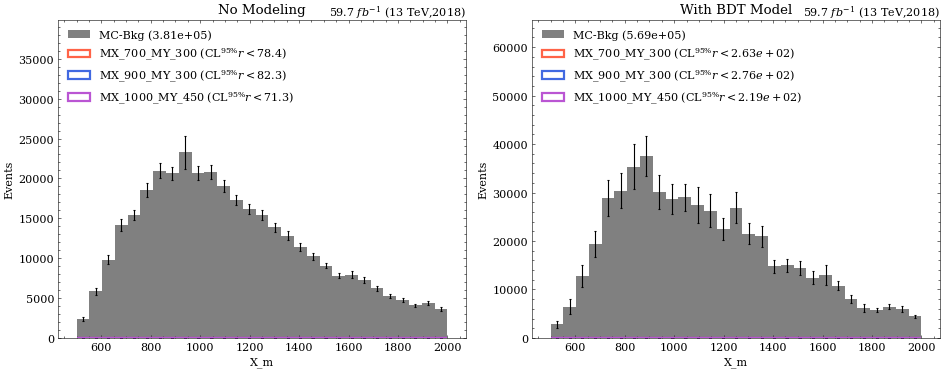

In [18]:
vr_bdt = train_and_evaluate(
    signal, bkg,
    features=['X_m','X_pt'],
    x_v='even_medium_btag', y_v='odd_medium_btag',
    x_r=y_vr[0][0], y_r=y_vr[0][1]
)